# Baseline Multiclass Classification Model

### Goal: Predict if image is one of the following classes: City, Desert, Coast



In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import rasterio
import os

### Some helper functions defined as follows:

- get_raster_images(): Given the name of the image directory, it will read all .tiff files in all directories within the parent directory and return the files as a numpy array of shape (NxHxWxC). Additionally, by specifying a MAX_READ path, the function will only read a certain number of images 

- get_images_and_label(): This is a higher level function that will call the get_raster_images() function. This function takes as input the full path to the directory as well as the directories to read. It will create labels based on the names of the directories. The mapping of name to label must be specified by passing in a dictionary containing these mappings

TO DO: For experimentation, loading a small subset of images onto disk is fine, but when we run on the full dataset we will want to make the get_images_and_label function a generator, so we can stream images in batches

In [3]:
def get_raster_images(IMG_PATH, MAX_READ=None):
    '''
    Input: IMG_PATH -- str, Name of the directory to read images from
            MAX_READ -- int, maximum number of images to read
    Output: images -- np.array, Array of images 
            file_names -- list, Names of tiles read
    '''
    
    images = []
    file_names = []
    # Walk the provided path 
    # Note: This will walk all folders in the path, so be careful where you point it 
    for path, dirname, files in os.walk(IMG_PATH):
        
        # Loop through the files in the path
        for read_count, file in enumerate(files):
            
            # If we read in the max number specified, break
            if MAX_READ and read_count == MAX_READ:
                break
                #return np.array(images, np.float32), file_names
            
            # Only read in files that end with .tif (raster images)
            elif file.endswith('.tif'):
                
                # Open the file and add it to a list
                with rasterio.open(os.path.join(path, file)) as src:
                    img = src.read()

                images.append(img)
                file_names.append(os.path.splitext(file)[0])
    
    # Need to get images in chape (NxHxWxC) to make life easier
    images_nchw = np.array(images, np.float32)
    images = np.moveaxis(images_nchw, 1, -1)

    return np.array(images, np.float32), file_names

In [4]:
# Label list contains the names of the folders the images are within. Ex: city, desert, coastline
def get_images_and_label(directory_path, directories, label_map, max_read=None, verbose=True):
    '''
    Inputs: directory_path -- str, Name of the path to higher level directory containing image folders
            directories -- list, Name of folders containing images (ex: ['city', 'desert'])
            label_map -- dict, Mapping of folder name to a label integer value
            max_read -- int, Maximum number of images to read per directory
            verbose -- bool, Whether to print info about reading files or not
    
    Outputs: final_train -- np.array, Numpy array containing all the images concatenated together 
                               in shape (NxHxWxC)
             final_labels -- np.array, Column vector of labels matching final_train indices
             file_names -- np.array, Numpy array of all the filenames read, concatenated into a single column vector
    
    '''
    
    labels = []
    data = []
    file_names = []
    
    # Loop through each directory and read in all the images
    for directory in directories:
        
        if verbose:
            print("Reading Directory: {}".format(directory))
        
        full_path = os.path.join(directory_path, directory)
        
        # Check if a maximum number of images to read per directory was set
        if max_read:
            images, files = get_raster_images(full_path, max_read)
        else:
            images, files = get_raster_images(full_path)
        
        if verbose:
            print("Images shape: {}".format(images.shape))
        
        # Add the newly read file names and images to respective lists
        file_names.append(files)    
        data.append(images)
        
        # If the directory name is in the label map, then create labels accordingly
        if directory in label_map:
            label_val = label_map[directory]
            num_images = images.shape[0]
            labels += [label_val]*num_images
        else:
            print("The directory name does not appear in the labels map ... make sure the directory is named after the desired label")
            raise KeyError 
    
    # Get all values into single numpy arrays
    file_names = np.concatenate(file_names, axis=0)
    final_labels = np.array(labels, ndmin=2).T
    final_train = np.concatenate(data, axis=0)
    
    return final_train, final_labels, file_names

### Call the functions specified above to get the data - store data in variables x_full and y_full

In [24]:
# Define the number of images to read per directory (per label)
# With the 3 directories this wil result in  a dataset size of 3*NUM_IMAGES 
NUM_IMAGES = 10

# Setup file paths
TRAIN_PATH = '../data/train'
CITY_DIR = "city"
COAST_DIR = "coast"
DESERT_DIR = "desert"

# Define Labels:
label_map = {
    'city': 0, 
    'desert': 1, 
    'coast': 2
}
# Setup inverse label map so we can lookup later on for verification
name_label_map = { val:key for key, val in label_map.items()}


# Setup a list of all image directories we want to read from
directories = [CITY_DIR, DESERT_DIR, COAST_DIR]


# Call the function to get the full data
x_full, y_full, file_names = get_images_and_label(directory_path=TRAIN_PATH, 
                                                  directories=directories, 
                                                  label_map=label_map, 
                                                  max_read=NUM_IMAGES, 
                                                  verbose=True)   

print("---------------------")
print("Shape of x_train: {}".format(x_full.shape))
print("Shape of labels: {}".format(y_full.shape))

Reading Directory: city
Images shape: (10, 256, 256, 4)
Reading Directory: desert
Images shape: (10, 256, 256, 4)
Reading Directory: coast
Images shape: (10, 256, 256, 4)
---------------------
Shape of x_train: (30, 256, 256, 4)
Shape of labels: (30, 1)


### Printout the filenames that were read to get a sense of the diversity of images

In [25]:
# Print which files were read
if (True):
    for ix, fname in enumerate(file_names):
        print("File: {}, Index: {}".format(fname, ix))

File: Madrid_111109_3840_768, Index: 0
File: Tokyo_004409_1792_1536, Index: 1
File: Berlin_092600_7168_4352, Index: 2
File: Paris_100226_7680_1792, Index: 3
File: Madrid_101822_1792_1792, Index: 4
File: SanFran_190801_1280_2816, Index: 5
File: Madrid_101822_1024_2048, Index: 6
File: Berlin_092506_7936_3328, Index: 7
File: Madrid_102006_1280_1280, Index: 8
File: Berlin_092507_2560_2560, Index: 9
File: Victoria_011215_512_2560, Index: 10
File: Gobi_024014_4608_3072, Index: 11
File: Gobi_035602_3840_1280, Index: 12
File: Victoria_011303_6656_2560, Index: 13
File: Victoria_004353_2048_2816, Index: 14
File: Sahara_101203_5120_1024, Index: 15
File: Sahara_103403_3584_3072, Index: 16
File: Gobi_035602_8192_4096, Index: 17
File: Victoria_021446_7168_512, Index: 18
File: Victoria_021652_2560_3072, Index: 19
File: EastFlorida_175451_4352_1792, Index: 20
File: EastFlorida_175932_2304_2304, Index: 21
File: SanFelipeMexico_154411_512_512, Index: 22
File: EastFlorida_175932_7680_2048, Index: 23
File

### Split the data in train and validation sets

#### Do a stratified split to make sure the classes are balanced in the training and validation sets respectively 

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idxs, valid_idxs = next(strat_split.split(x_full, y_full))

x_train, x_valid = x_full[train_idxs], x_full[valid_idxs]
y_train, y_valid = y_full[train_idxs], y_full[valid_idxs]


print("x_train shape: {}".format(x_train.shape))
print("x_valid shape: {}".format(x_valid.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_valid shape: {}".format(y_valid.shape))

x_train shape: (24, 256, 256, 4)
x_valid shape: (6, 256, 256, 4)
y_train shape: (24, 1)
y_valid shape: (6, 1)


In [34]:
# Check to make sure the classes are balanced
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))

(array([0, 1, 2]), array([8, 8, 8]))
(array([0, 1, 2]), array([2, 2, 2]))


In [48]:
# Printout the filenames in each train/valid set so we have a record of what files comprised each
print("Train set files: ")
print(file_names[train_idxs])

print("Validation set files: ")
print(file_names[valid_idxs])

Train set files: 
['Berlin_092600_7168_4352' 'EastFlorida_175451_4352_1792'
 'Tokyo_004409_1792_1536' 'Madrid_101822_1792_1792'
 'Madrid_102006_1280_1280' 'Victoria_021446_7168_512'
 'Victoria_011303_6656_2560' 'EastFlorida_175745_6656_4096'
 'Berlin_092506_7936_3328' 'EastTexas_162155_7424_2560'
 'Victoria_011215_512_2560' 'Madrid_111109_3840_768'
 'Berlin_092507_2560_2560' 'EastFlorida_175932_7680_2048'
 'SanFran_190801_1280_2816' 'Victoria_004353_2048_2816'
 'SanFelipeMexico_154411_512_512' 'Gobi_035602_8192_4096'
 'Victoria_021652_2560_3072' 'Gobi_024014_4608_3072'
 'EastTexas_162156_5888_1792' 'EastFlorida_175544_1792_1280'
 'EastTexas_162206_6912_3840' 'Sahara_101203_5120_1024']
Validation set files: 
['SanFelipeMexico_154147_4096_1024' 'Sahara_103403_3584_3072'
 'EastFlorida_175932_2304_2304' 'Madrid_101822_1024_2048'
 'Gobi_035602_3840_1280' 'Paris_100226_7680_1792']


### Printout some images to make sure they look alright

 NOTE: PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared

In [41]:
def show_rand_images_and_labels(images, labels, name_label_map, num_to_show, band_to_show, random=True):
    N = images.shape[0]
    
    for ix in range(num_to_show):
        if random:
            ix = np.random.choice(N, 1)
        else:
            ix = np.array([ix]) # Hack to get it to work for non random choice

        img = images[ix, :, :, band_to_show]
        plt.imshow(img[0, :, :])
        plt.show()
        label = labels[ix, :][0][0]
        print("Label Name and Value: {}, {}".format(name_label_map[label], label))
    

### Print subset of training images

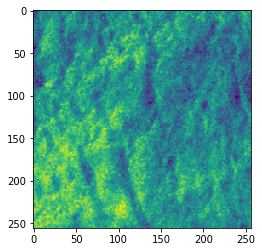

Label Name and Value: desert, 1


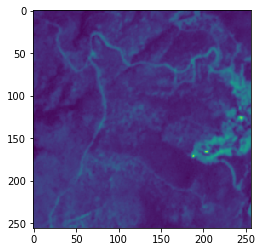

Label Name and Value: coast, 2


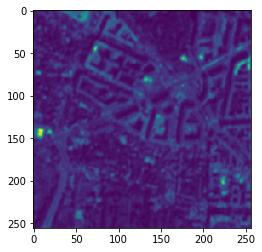

Label Name and Value: city, 0


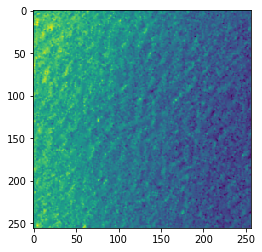

Label Name and Value: coast, 2


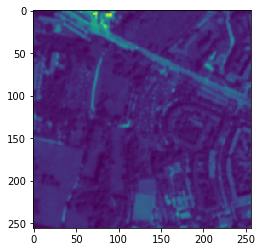

Label Name and Value: city, 0


In [42]:
show_rand_images_and_labels(x_train, y_train, name_label_map, num_to_show=5, band_to_show=1)

### Print full set of validation images and make sure they are okay

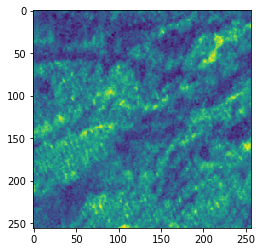

Label Name and Value: coast, 2


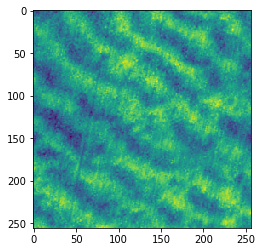

Label Name and Value: desert, 1


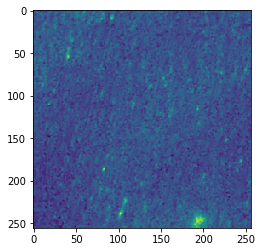

Label Name and Value: coast, 2


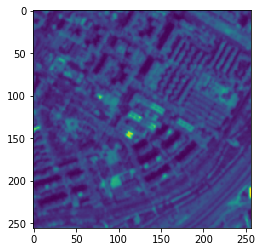

Label Name and Value: city, 0


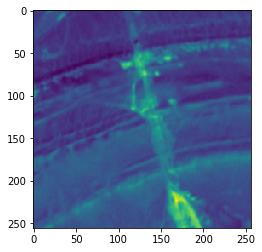

Label Name and Value: desert, 1


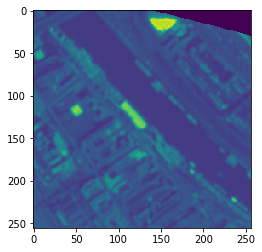

Label Name and Value: city, 0


In [43]:
show_rand_images_and_labels(x_valid, 
                            y_valid, 
                            name_label_map, 
                            num_to_show=6, 
                            band_to_show=1, 
                            random=False)

## Setup the model
Note: For the baseline, I ended up using only the RGB bands of the image, not the 4th NIR band. This will make the baseline simpler, but also, the default ResNet-50 architecture was made for an image with 3 channels not 4, so we might have to roll our own modified architecture to use the NIR band (which we definitely want to do) and should be as simple as copying the code from the below link and modifying:

https://github.com/keras-team/keras/blob/master/keras/applications/resnet50.py



In [45]:
# Try training on only RGB channels with ResNetModel
# Cutout the 4th band
x_train_rgb = x_train[:, :, :, :3]
print("x_train_rgb shape: {}".format(x_train_rgb.shape))

x_valid_rgb = x_valid[:, :, :, :3]
print("x_valid_rgb shape: {}".format(x_valid_rgb.shape))


x_train_rgb shape: (24, 256, 256, 3)
x_valid_rgb shape: (6, 256, 256, 3)


In [46]:
import tensorflow as tf
# Define model

INPUT_SHAPE_RGB = (256, 256, 3) # Changed to 3 chanels for baseline

# Define the model
base_model = tf.keras.applications.ResNet50(include_top=True, # This includes the final fully connected layers
                                            weights=None, # This makes sure we don't use the pretrained Imagenet weights
                                            input_shape=INPUT_SHAPE_RGB, 
                                            classes=3) 


base_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 128, 128, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Setup the optimizer and run

Note: I created the label (y_full) array so that it contains the numbers 0,1,2 as labels. In order to run the model with these values we have to use the "sparse_categorical_crossentropy" loss function. To use the normal loss function we need to one-hot encode the labels. I also found that apparently we can only have labels of the numbers between [0,3), so if we add more labels we will need to change the way we are labeling

In [47]:
# Setup the model optimizer and run it
learning_rate = 1e-4
base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
                   loss=tf.keras.losses.sparse_categorical_crossentropy, 
                   metrics=['accuracy'])

base_model.fit(x=x_train_rgb, # RGB training data
               y=y_train,  # Labels as defined
               batch_size=8, 
               epochs=10, 
               validation_data=[x_valid_rgb, y_valid],
               shuffle=True, 
               callbacks=None, # We can use normal Keras callbacks (wil lwant to use Tensorboard probably)
               verbose=True)

Train on 24 samples, validate on 6 samples
Epoch 1/10
24/24 [==============================] - 57s 2s/step - loss: 2.1629 - acc: 0.3750 - val_loss: 1.0979 - val_acc: 0.3333
Epoch 2/10
24/24 [==============================] - 39s 2s/step - loss: 0.7502 - acc: 0.7500 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 3/10
24/24 [==============================] - 37s 2s/step - loss: 0.4557 - acc: 0.8333 - val_loss: 1.1055 - val_acc: 0.3333
Epoch 4/10
24/24 [==============================] - 36s 2s/step - loss: 0.4841 - acc: 0.8333 - val_loss: 1.1200 - val_acc: 0.3333
Epoch 5/10
24/24 [==============================] - 37s 2s/step - loss: 0.4520 - acc: 0.8333 - val_loss: 1.1467 - val_acc: 0.3333
Epoch 6/10
24/24 [==============================] - 37s 2s/step - loss: 0.3114 - acc: 0.8750 - val_loss: 1.1823 - val_acc: 0.3333
Epoch 7/10
24/24 [==============================] - 36s 2s/step - loss: 0.2687 - acc: 0.9583 - val_loss: 1.2174 - val_acc: 0.3333
Epoch 8/10
24/24 [=============================

### Conclusion:

Wooo, we can finally get an accuracy better than 50% on something. Looks like we can overfit pretty easily. Lets get to work using more complex models and more data now 